Let's break the notebook into separate steps. Feel free to navigate the notebook and comment if you have any suggestions.

Step 0: Import Datasets \
Step 1: Detect Dogs\
Step 2: Create a CNN to Classify Dog Breeds (from Scratch)\
Step 3: Create a CNN to Classify Dog Breeds (using Transfer Learning)\
Step 4: Test

# Initializations
At first we need to import the libraries. It is considered as standard imports.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

We will be using this function mostly everywhere to run our experiments deterministically. Random functions of Numpy and Pandas will behave deterministically after this. To learn more about Deterministic Neural Networks please check out [this notebook](https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch)

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

Have you wondered about why they use 42? Do you want to know about the reason behind 42? Look [Here ](https://en.wikipedia.org/wiki/Phrases_from_The_Hitchhiker%27s_Guide_to_the_Galaxy#Answer_to_the_Ultimate_Question_of_Life.2C_the_Universe_and_Everything_.2842.29):p



In [3]:
#Read the dataset 
PATH = '../input/dog-breed-identification/'
labels = pd.read_csv(PATH+'labels.csv')
labelnames = pd.read_csv(PATH + 'sample_submission.csv').keys()[1:]
print("Train folder has ", len(os.listdir(PATH+'train')),'images which matches with label\'s', len(labels),'images')

Train folder has  10222 images which matches with label's 10222 images


In [4]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.85)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(8689, 121) (1533, 121)


In [5]:
labels.head(5)

,id,breed,target,rank
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19,1.0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37,1.0
2,001cdf01b096e06d78e9e5112d419397,pekinese,85,1.0
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15,1.0
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49,1.0


Using the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](https://pytorch.org/vision/stable/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](https://pytorch.org/vision/stable/transforms.html)!

In [6]:
 # Image transformations
img_transform = {
    'valid':transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size = 256),
        transforms.RandomRotation(degrees = 30),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'test':transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

I resized the pictures to 256256 and then cropped the image into 224224 randomly to avoid squashed images and normalized it using Imagenet's mean and standard deviation after converting to tensor. for train, test and valid set.

For training images, I used data augmentation which includes random rotation of 30 degrees and horizontal flip.

In [7]:
class DogBreedDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, img_dir, label, transform):
        'Initialization'
        self.img_dir = img_dir
        self.transform = transform
        self.label = label

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.label)

    def __getitem__(self, index):
        if self.label is not None:
            img_name = '{}.jpg'.format(self.label.iloc[index, 0])
            fullname = self.img_dir + img_name
            image = Image.open(fullname)
            label = self.label.iloc[index, 1:].astype('float').to_numpy()
            label = np.argmax(label)
            if self.transform:
                image = self.transform(image)
            return [image, label]
        

In [8]:
batch_size = 12
num_workers = 4
train_img = DogBreedDataset(PATH+'train/', train, transform = img_transform['train'])
valid_img = DogBreedDataset(PATH+'train/', valid, transform = img_transform['valid'])


dataloaders={
    'train':torch.utils.data.DataLoader(train_img, batch_size, num_workers = num_workers, shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_img, batch_size, num_workers = num_workers, shuffle=False)
}


In [9]:
use_cuda = torch.cuda.is_available()


In [10]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([12, 3, 224, 224]) torch.Size([12])


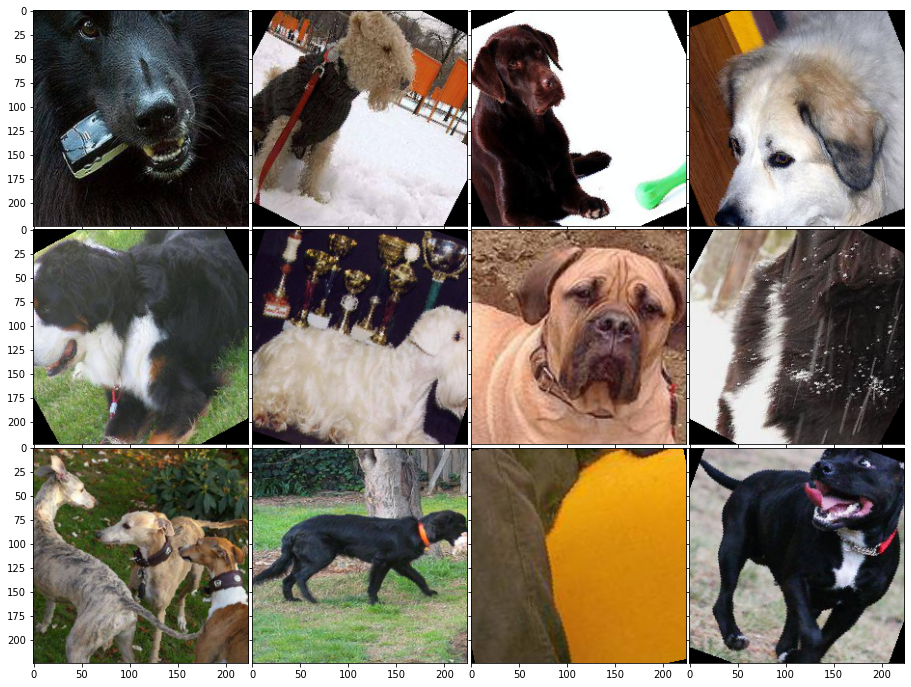

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid
img, label = next(iter(dataloaders['train']))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

# CNN Model from scratch

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
    
        # Convolution layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        
        # Max pooling layer (divides image size by 2)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, 120)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        ## Define forward behavior
        
        # Sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten image input
        x = x.view(-1, 128 * 28 * 28)
        # Dropout layer
        x = self.dropout(x)
        # 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Dropout layer
        x = self.dropout(x)
        # 2nd hidden layer
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

I used three convolutional layers with relu activations which are followed by maxpool layers. Also, used two fully connected layers. Between fully connected layers, dropout technique with probability = 0.25 is used to avoid the overfitting.

In [13]:
!pip install torchsummary

In [14]:
#let's see the model
from torchsummary import summary
summary(model_scratch, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
           Dropout-7               [-1, 100352]               0
            Linear-8                  [-1, 500]      50,176,500
           Dropout-9                  [-1, 500]               0
           Linear-10                  [-1, 120]          60,120
Total params: 50,329,868
Trainable params: 50,329,868
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 27.57
Params size (MB): 191.99
Es

the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_scratch.parameters(), lr=0.01, momentum = 0.9)

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch: %d \tBatch: %d \tTraining Loss: %.6f' %(epoch, batch_idx + 1, train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('BOOM! Validation loss decreased ({:.4f} --> {:.4f}).  Saving model...'.format(valid_loss_min,valid_loss))
            valid_loss_min = valid_loss    

    # return trained model
    return model
# train the model
model_scratch = train(10, dataloaders, model_scratch, optimizer, 
                      criterion, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Batch: 1 	Training Loss: 4.818271
Epoch: 1 	Batch: 101 	Training Loss: 4.794408
Epoch: 1 	Batch: 201 	Training Loss: 4.786707
Epoch: 1 	Batch: 301 	Training Loss: 4.786314
Epoch: 1 	Batch: 401 	Training Loss: 4.786539
Epoch: 1 	Batch: 501 	Training Loss: 4.784029
Epoch: 1 	Batch: 601 	Training Loss: 4.780817
Epoch: 1 	Batch: 701 	Training Loss: 4.777148
Epoch: 1 	Training Loss: 4.7749 	Validation Loss: 4.6879
BOOM! Validation loss decreased (inf --> 4.6879).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 4.789743
Epoch: 2 	Batch: 101 	Training Loss: 4.721186
Epoch: 2 	Batch: 201 	Training Loss: 4.720475
Epoch: 2 	Batch: 301 	Training Loss: 4.716143
Epoch: 2 	Batch: 401 	Training Loss: 4.715170
Epoch: 2 	Batch: 501 	Training Loss: 4.713479
Epoch: 2 	Batch: 601 	Training Loss: 4.705013
Epoch: 2 	Batch: 701 	Training Loss: 4.705452
Epoch: 2 	Training Loss: 4.7063 	Validation Loss: 4.6598
BOOM! Validation loss decreased (4.6879 --> 4.6598).  Saving model...
Epoch: 3 	Batch: 

<All keys matched successfully>

as you can see it has a pretty big loss value. Training a model from scratch and getting good loss can be hard with epochs like 10. So let's move to transfer learning models which are pretrained. 

In [17]:
resnet50 = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
##  Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False
    
# replace the last fully connected layer with a Linnear layer 133 output
in_features = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(in_features, 120)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [19]:
criterion_transfer = nn.CrossEntropyLoss()
model_transfer_grad_paramaters = filter(lambda p: p.requires_grad, model_transfer.parameters())
optimizer_transfer = torch.optim.SGD(model_transfer_grad_paramaters, lr=0.01)

In [20]:
n_epochs = 10
# train the model
model_transfer =  train(n_epochs, dataloaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Batch: 1 	Training Loss: 4.848300
Epoch: 1 	Batch: 101 	Training Loss: 4.733810
Epoch: 1 	Batch: 201 	Training Loss: 4.570956
Epoch: 1 	Batch: 301 	Training Loss: 4.431541
Epoch: 1 	Batch: 401 	Training Loss: 4.301669
Epoch: 1 	Batch: 501 	Training Loss: 4.174578
Epoch: 1 	Batch: 601 	Training Loss: 4.059970
Epoch: 1 	Batch: 701 	Training Loss: 3.954469
Epoch: 1 	Training Loss: 3.9319 	Validation Loss: 2.6085
BOOM! Validation loss decreased (inf --> 2.6085).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 3.866406
Epoch: 2 	Batch: 101 	Training Loss: 3.090753
Epoch: 2 	Batch: 201 	Training Loss: 3.007935
Epoch: 2 	Batch: 301 	Training Loss: 2.942505
Epoch: 2 	Batch: 401 	Training Loss: 2.871669
Epoch: 2 	Batch: 501 	Training Loss: 2.817320
Epoch: 2 	Batch: 601 	Training Loss: 2.772448
Epoch: 2 	Batch: 701 	Training Loss: 2.732162
Epoch: 2 	Training Loss: 2.7248 	Validation Loss: 1.4711
BOOM! Validation loss decreased (2.6085 --> 1.4711).  Saving model...
Epoch: 3 	Batch: 

# SubmissionAdam

In [21]:
submission = pd.read_csv(PATH+'/sample_submission.csv')
output = pd.DataFrame(index=submission.index, columns=submission.keys() )
output['id'] = submission['id']
submission['target'] =  [0] * len(submission)

#will do this part later :3 